## 구매군집에 대한 피쳐 선택 및 예측 모델 생성하기

#### 1. 모듈 불러오기

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime, timedelta

from matplotlib import font_manager, rc, cm
%matplotlib inline

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

import glob
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean

from tqdm.notebook import tqdm
from pycaret.regression import *
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#### 2. 데이터 불러오기 / 전처리

(1) sns 검색데이터 / 구매 데이터 / 날씨 데이터 / 군집 기준 데이터 불러오기

In [2]:
beatuy_label = pd.read_csv('beauty_label_6.csv')
food_label = pd.read_csv('food_label_7.csv')
electric_label = pd.read_csv('elec_label_5.csv')

sns_data = pd.read_csv('sns_data 이상치 대체.csv')
climate_data = pd.read_csv('climate_data_date_스케일링전.csv')

input_file = r'C:\Users\gby1349\python\공모전\군집화 이후' 

all_file_list = glob.glob(os.path.join(input_file, 'buy_data*'))
all_data = [] 

for file in all_file_list:
    df = pd.read_csv(file) 
    all_data.append(df)
    
buy_data = pd.concat(all_data, axis=0, ignore_index=True)

(2) 날씨 데이터 전처리
- 카테고리 변수 인코딩 : 강수계급 / 바람계급 / 구릅 계급 인코딩
- 주 / 날짜 정보 제거 

In [3]:
climate_data = climate_data.set_index('date')

# 주/날짜 정보 제거 
del climate_data['week'], climate_data['day']

# 카테고리 변수 인코딩
climate_data['강수계급'] = climate_data['강수계급'].agg(lambda x: 0 if x == '무강수' else 1 if x == '0.1mm이상 1mm미만' 
                         else 2 if x == '1mm이상 10mm미만' else 3 if x == '10mm이상 30mm미만' else 4)

climate_data['바람계급'] = climate_data['바람계급'].agg(lambda x: 0 if x == '0.5m/s이상 3.4m/s미만' else 1)

climate_data['구름계급'] = climate_data['구름계급'].agg(lambda x : 0 if x == '맑음' else 1 if x == '구름조금' 
                                                else 2 if x == '구름많음' else 3)

(3) 구매 데이터와 SNS 데이터 merge
- 구매 데이터와 SNS 데이터 merge를 위한 전처리: buy_data(num) / sns_data(index) 제거
- 클러스터링 간의 나눈(대분류 안에 소분류 상품들에 대한 군집) 군집번호 merge

In [4]:
# buy_data / sns_Data 불필요한 정보 제거 
buy_data = buy_data.iloc[:,1:]
sns_data = sns_data.iloc[:,2:]

In [5]:
# 군집 번호를 결합하기 위해서 전처리(칼럼명 변경)
beatuy_label = beatuy_label.rename(columns = {'소분류' : 'sm_cat'})
food_label = food_label.rename(columns = {'소분류' : 'sm_cat'})
electric_label = electric_label.rename(columns = {'소분류' : 'sm_cat'})

# merge를 위해 소분류 별 대응 군집 번호 대한 데이터프레임 생성
label =  pd.concat([beatuy_label, food_label, electric_label], axis = 0)  

In [6]:
# 구매 데이터 / sns 데이터 / 군집 데이터 merge 형성
new = pd.merge(buy_data, sns_data, on = ['date','big_cat','sm_cat'], how = 'inner')
new_label = pd.merge(new, label, on = ['sm_cat'], how= 'inner')

(4) 해당 군집에 따른 데이터 추출
- query문에 대분류(식품 / 뷰티 / 냉난방가전 기입), 군집 번호(대분류 내) 입력
- 나이대 정보 인코딩으로 활용하기 위해서 전처리

- 예) 구매 군집 中 식품 클러스터링 01, 오이/가지

In [11]:
example = new_label.query('big_cat == "식품" and labels ==1 and sm_cat == "오이/가지"')
example['age'] = example['age'].agg(lambda x: str(x) + "대")
example = example[['qty','date','sex','age','sm_cat']] # sm_cat: query문이 제대로 추출했는지 확인용 

example['qty'] = example['qty'].fillna(0);example.head()

,qty,date,sex,age,sm_cat
1355000,1.0,2018-01-01,F,20대,오이/가지
1355001,8.0,2018-01-01,F,30대,오이/가지
1355002,6.0,2018-01-01,F,40대,오이/가지
1355003,1.0,2018-01-01,F,50대,오이/가지
1355004,1.0,2018-01-01,M,20대,오이/가지


In [12]:
del example['sm_cat'] # 확인 후 소분류명 삭제 

In [13]:
# 해당 군집과 대응 되는 날씨 변수명 선택 / 계절 군집도 고려(오이/가지는 봄, 가을로 선택)
climate_date_01 = climate_data[['최저기온','rain','최대풍속','평균풍속','평균상대습도','평균증기압', '평균현지기압',
                                '합계일조시간','NO2','O3','최고자외선지수','weekrain','threerain','기온편차','실효습도','weekend']]

In [14]:
# 날씨 데이터 와 최종 데이터 합치기 
climate_date_01 = climate_date_01.reset_index()
example_food_01 = pd.merge(example, climate_date_01, on = 'date', how= 'left')

In [15]:
#특정 계쩔에 대한 데이터 예측을 위해 월 컬럼 생성 후 데이터 정제 / 이후 울 데이터 삭제
example_food_01['date'] = pd.to_datetime(example_food_01 ['date'])
example_food_01['월'] = example_food_01['date'].dt.month

food_01_category = example_food_01.query('월 == 3 or 월 ==4 or 월 == 10')
del food_01_category['월']

# 최종 날짜 데이터를 index화
food_01_category = food_01_category.set_index('date')

#### 3. 데이터 split 후 모델 학습 
- Auto ML(Pycrat)를 활용해 모델 비교 후 모델 선택 
- train/test 나눌 때 test_size = 20%, 셔플 및 시드값은 0으로 고정
- 학습하는 과정에 용의성을 위해서 x_train과 그에 대응되는 y값(y_train / 날짜별(연령 및 성별) 판매량 값

In [16]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(food_01_category.iloc[:,1:], food_01_category.iloc[:,0], 
                                                    test_size=0.2, shuffle=True, random_state=0)
train = pd.concat([x_train, y_train], axis = 1)

####  (1) 모델 생성 후 성능 비교 
- 가, Categroy 변수(나이 / 성별 / 주말 여부)에 대해 모델 자동 인코딩 
- 나. 극단값에 대해서는 정규화(Zscore : 정규화)
- 다. fold 기준: 3회 검증 및 시계열로 인식
- 라. 시드값은 0으로 고정
- 마. null값은 평균으로 대체(기본 데이터가 null값이 없으므로 의미 X)

In [17]:
from pycaret.regression import *
reg = setup(data=train,
            target='qty',
            numeric_imputation = 'mean',
            normalize = True,
            normalize_method = 'zscore',
            categorical_features = ['age','sex','weekend'],
            silent= True,
            fold_strategy = 'timeseries',
            fold = 3,
            session_id = 0)

,Description,Value
0,session_id,0
1,Target,qty
2,Original Data,"(1204, 19)"
3,Missing Values,False
4,Numeric Features,15
5,Categorical Features,3
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(842, 22)"


- 모델 성능 비교(R2를 기준) 

In [18]:
best_5_d = compare_models(sort = 'R2', n_select = 3)
print(best_5_d)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,2.6754,13.5738,3.6802,0.7372,0.4925,0.7109,0.1933
catboost,CatBoost Regressor,2.6233,13.8930,3.7212,0.7313,0.4761,0.6830,0.6100
gbr,Gradient Boosting Regressor,2.7349,14.6621,3.8271,0.7165,0.4772,0.7074,0.0500
et,Extra Trees Regressor,2.7487,15.7687,3.9687,0.6962,0.4624,0.6589,0.0567
rf,Random Forest Regressor,2.8780,16.7743,4.0948,0.6764,0.4890,0.7275,0.0767
xgboost,Extreme Gradient Boosting,2.9476,18.1935,4.2652,0.6481,0.5271,0.7483,0.9067
ada,AdaBoost Regressor,3.4664,19.3898,4.4023,0.6248,0.6131,1.1754,0.0433
lr,Linear Regression,3.5001,19.6769,4.4342,0.6209,0.5782,1.1092,0.9967
ridge,Ridge Regression,3.4904,19.6798,4.4344,0.6209,0.5748,1.0965,0.7967
br,Bayesian Ridge,3.4836,19.7257,4.4396,0.6200,0.5724,1.0845,0.0100


[LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0), <catboost.core.CatBoostRegressor object at 0x000002740EDED820>, GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_chang

#### (2)  모델 생성 및 튜닝 (단일 모델 3개 / 배깅 모델 3개 / 부스팅 3개 / 블렌딩 3개)
- R을 기준으로 상위 모델 선정 
- 단 다른 5개의 성능 지표 비교해서 결정(Gradient Boosting Regressor 대신 Extra Trees Regressor 모델 선정 : 다른 성능 지표 향상)

In [20]:
tuned_models = []

- 가. 단일 모델 생성

In [21]:
### CatBoost Regressor 튜닝(상위 모델 1번)
model_01 = create_model('catboost')

model_01 = tune_model(model_01, fold= 3, n_iter = 100, optimize = 'R2', verbose = True, choose_better = True)
tuned_models.append(model_01)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,2.6296,13.6531,3.6950,0.7162,0.4661,0.6723
1,2.6217,14.2550,3.7756,0.7427,0.4691,0.6575
2,2.4460,12.1481,3.4854,0.7675,0.4524,0.6478
Mean,2.5658,13.3520,3.6520,0.7421,0.4625,0.6592
SD,0.0848,0.8861,0.1223,0.0209,0.0073,0.0101


In [22]:
#  Extra Trees Regressor 튜닝(상위 모델 2번)
model_02 = create_model('et') 

model_02= tune_model(model_02, fold= 3, n_iter = 100, optimize = 'R2', verbose = True, choose_better = True)
tuned_models.append(model_02)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,2.6125,14.1886,3.7668,0.7051,0.4486,0.6332
1,2.7331,15.9427,3.9928,0.7123,0.4508,0.6392
2,2.6116,13.8397,3.7202,0.7351,0.4454,0.6361
Mean,2.6524,14.6570,3.8266,0.7175,0.4483,0.6361
SD,0.0571,0.9202,0.1191,0.0128,0.0022,0.0024


In [23]:
#  Light Gradient Boosting Machine 튜닝 (상위 모델 3번)
model_03 = create_model('lightgbm')

model_03 = tune_model(model_03, fold= 3, n_iter = 100, optimize = 'R2', verbose = True, choose_better = True)
tuned_models.append(model_03)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,2.9370,15.7526,3.9690,0.6726,0.4991,0.7669
1,2.8297,15.6390,3.9546,0.7177,0.5065,0.7032
2,2.4557,11.0254,3.3204,0.7890,0.4673,0.6776
Mean,2.7408,14.1390,3.7480,0.7264,0.4910,0.7159
SD,0.2063,2.2022,0.3024,0.0479,0.0170,0.0375


- 나. 앙상블 모델 생성: 배깅

In [24]:
prediction_models = []

In [25]:
bag_01_15 = ensemble_model(model_01 , n_estimators = 15, fold=3, optimize = 'R2')
prediction_models.append(bag_01_15)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,2.8155,15.1969,3.8983,0.6841,0.4730,0.7347
1,2.6956,14.9543,3.8671,0.7301,0.4653,0.6671
2,2.4223,11.5472,3.3981,0.7790,0.4409,0.6269
Mean,2.6445,13.8994,3.7212,0.7311,0.4597,0.6762
SD,0.1645,1.6663,0.2288,0.0387,0.0137,0.0445


In [26]:
bag_02_15 = ensemble_model(model_02, n_estimators = 15, fold=3, optimize = 'R2')
prediction_models.append(bag_02_15 )

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,2.7050,14.7223,3.8370,0.6940,0.4635,0.6778
1,2.7714,16.3934,4.0489,0.7041,0.4608,0.6685
2,2.6208,13.9030,3.7287,0.7339,0.4434,0.6430
Mean,2.6991,15.0062,3.8715,0.7107,0.4559,0.6631
SD,0.0616,1.0363,0.1330,0.0170,0.0089,0.0147


In [28]:
bag_03_15 = ensemble_model(model_03, n_estimators = 15, fold=3, optimize = 'R2')
prediction_models.append(bag_03_15)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,2.8274,14.8904,3.8588,0.6905,0.4839,0.7397
1,2.6943,14.7543,3.8411,0.7337,0.4790,0.6730
2,2.4163,11.2907,3.3602,0.7839,0.4415,0.6441
Mean,2.6460,13.6452,3.6867,0.7360,0.4681,0.6856
SD,0.1713,1.6658,0.2310,0.0382,0.0190,0.0401


- 나. 앙상블 모델 생성: 부스팅

In [29]:
boo_01 = ensemble_model(model_01, method = 'Boosting', fold=3, optimize='R2')
prediction_models.append(boo_01)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,2.9244,15.4762,3.9340,0.6783,0.5039,0.8098
1,2.7180,15.0216,3.8758,0.7289,0.4836,0.6807
2,2.4999,12.2375,3.4982,0.7658,0.4555,0.6540
Mean,2.7141,14.2451,3.7693,0.7243,0.4810,0.7148
SD,0.1733,1.4317,0.1932,0.0359,0.0198,0.0680


In [30]:
boo_02 = ensemble_model(model_02, method = 'Boosting', fold=3, optimize='R2')
prediction_models.append(boo_02)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,2.8007,13.8679,3.7240,0.7117,0.4983,0.8029
1,2.8394,15.9486,3.9936,0.7121,0.4840,0.7662
2,2.6690,13.8546,3.7222,0.7349,0.4706,0.7419
Mean,2.7697,14.5570,3.8132,0.7196,0.4843,0.7703
SD,0.0730,0.9840,0.1275,0.0108,0.0113,0.0251


In [31]:
boo_03 = ensemble_model(model_03, method = 'Boosting', fold=3, optimize='R2')
prediction_models.append(boo_03)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,2.9043,15.2329,3.9029,0.6834,0.5140,0.7922
1,2.7268,14.8084,3.8482,0.7327,0.4894,0.7085
2,2.4659,12.0516,3.4715,0.7694,0.4572,0.6660
Mean,2.6990,14.0310,3.7409,0.7285,0.4868,0.7223
SD,0.1801,1.4103,0.1918,0.0352,0.0233,0.0524


나. 앙상블 모델 생성: Blending(블렌딩)

In [32]:
blend_3_soft = blend_models(estimator_list=[model_01, model_02, model_03], fold=3, optimize='R2')
prediction_models.append(blend_3_soft)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,2.5591,13.1167,3.6217,0.7274,0.4427,0.6269
1,2.5659,13.7868,3.7131,0.7512,0.4529,0.6163
2,2.3869,11.4267,3.3803,0.7813,0.4336,0.6157
Mean,2.5040,12.7767,3.5717,0.7533,0.4430,0.6196
SD,0.0829,0.9930,0.1404,0.0221,0.0079,0.0052


#### (3) 생성된 모델에 대한 Train 데이터에 대한 성과 확인

In [33]:
for model in tuned_models:
    print(model.__class__.__name__)
    display(predict_model(model))

CatBoostRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,2.4905,12.8151,3.5798,0.7224,0.4593,0.5792


,최저기온,rain,최대풍속,평균풍속,평균상대습도,평균증기압,평균현지기압,합계일조시간,NO2,O3,...,실효습도,sex_M,age_20대,age_30대,age_40대,age_50대,age_60대,weekend_평일,qty,Label
0,-0.860771,-0.445911,1.672894,2.769138,-1.550796,-1.404412,0.410648,0.235111,-1.951832,1.368541,...,-1.025292,0.0,0.0,1.0,0.0,0.0,0.0,0.0,13.0,20.179855
1,-0.982599,-0.188362,1.884870,2.806834,-0.827121,-1.161950,0.937041,-1.163371,-1.764122,1.163974,...,0.362946,0.0,0.0,1.0,0.0,0.0,0.0,1.0,18.0,15.234767
2,-0.267890,2.740451,1.629634,1.752935,-0.431149,-0.625564,-0.401436,-1.023951,-0.689804,0.588123,...,-1.231751,0.0,0.0,1.0,0.0,0.0,0.0,1.0,18.0,20.417628
3,-0.503770,-0.513456,-0.365543,-0.369046,-0.417121,-0.469094,0.432934,0.916003,-0.119128,0.125902,...,-0.502853,0.0,1.0,0.0,0.0,0.0,0.0,1.0,6.0,2.581709
4,-0.889991,-0.253612,0.391517,0.676500,-0.049207,-0.858076,0.381176,0.189858,0.220400,0.592585,...,-0.313778,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.068461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,-1.414770,-0.461639,1.090607,0.997732,-1.816519,-1.457026,1.030571,1.006809,-0.935248,0.757659,...,-1.516076,0.0,0.0,0.0,0.0,1.0,0.0,1.0,13.0,10.919672
358,-1.698250,-0.504176,2.282002,2.115865,-2.218989,-1.679892,0.542021,0.942603,-1.109574,0.297844,...,-1.026224,1.0,0.0,0.0,1.0,0.0,0.0,1.0,8.0,5.985041
359,1.682300,-0.488908,0.808548,1.413171,-0.375578,0.905506,-0.135460,0.687000,-1.724267,0.570251,...,0.028103,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.967291
360,-0.027769,1.618741,0.709914,0.094269,1.225685,0.547232,-0.964729,-1.147167,0.700485,-1.263406,...,0.019609,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,4.547883


ExtraTreesRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,2.5176,13.0695,3.6152,0.7169,0.4280,0.5994


,최저기온,rain,최대풍속,평균풍속,평균상대습도,평균증기압,평균현지기압,합계일조시간,NO2,O3,...,실효습도,sex_M,age_20대,age_30대,age_40대,age_50대,age_60대,weekend_평일,qty,Label
0,-0.860771,-0.445911,1.672894,2.769138,-1.550796,-1.404412,0.410648,0.235111,-1.951832,1.368541,...,-1.025292,0.0,0.0,1.0,0.0,0.0,0.0,0.0,13.0,16.938702
1,-0.982599,-0.188362,1.884870,2.806834,-0.827121,-1.161950,0.937041,-1.163371,-1.764122,1.163974,...,0.362946,0.0,0.0,1.0,0.0,0.0,0.0,1.0,18.0,18.435485
2,-0.267890,2.740451,1.629634,1.752935,-0.431149,-0.625564,-0.401436,-1.023951,-0.689804,0.588123,...,-1.231751,0.0,0.0,1.0,0.0,0.0,0.0,1.0,18.0,19.454060
3,-0.503770,-0.513456,-0.365543,-0.369046,-0.417121,-0.469094,0.432934,0.916003,-0.119128,0.125902,...,-0.502853,0.0,1.0,0.0,0.0,0.0,0.0,1.0,6.0,4.213511
4,-0.889991,-0.253612,0.391517,0.676500,-0.049207,-0.858076,0.381176,0.189858,0.220400,0.592585,...,-0.313778,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.614461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,-1.414770,-0.461639,1.090607,0.997732,-1.816519,-1.457026,1.030571,1.006809,-0.935248,0.757659,...,-1.516076,0.0,0.0,0.0,0.0,1.0,0.0,1.0,13.0,8.171864
358,-1.698250,-0.504176,2.282002,2.115865,-2.218989,-1.679892,0.542021,0.942603,-1.109574,0.297844,...,-1.026224,1.0,0.0,0.0,1.0,0.0,0.0,1.0,8.0,6.976606
359,1.682300,-0.488908,0.808548,1.413171,-0.375578,0.905506,-0.135460,0.687000,-1.724267,0.570251,...,0.028103,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2.560022
360,-0.027769,1.618741,0.709914,0.094269,1.225685,0.547232,-0.964729,-1.147167,0.700485,-1.263406,...,0.019609,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,5.023848


LGBMRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.6391,13.6248,3.6912,0.7049,0.4804,0.6106


,최저기온,rain,최대풍속,평균풍속,평균상대습도,평균증기압,평균현지기압,합계일조시간,NO2,O3,...,실효습도,sex_M,age_20대,age_30대,age_40대,age_50대,age_60대,weekend_평일,qty,Label
0,-0.860771,-0.445911,1.672894,2.769138,-1.550796,-1.404412,0.410648,0.235111,-1.951832,1.368541,...,-1.025292,0.0,0.0,1.0,0.0,0.0,0.0,0.0,13.0,17.988856
1,-0.982599,-0.188362,1.884870,2.806834,-0.827121,-1.161950,0.937041,-1.163371,-1.764122,1.163974,...,0.362946,0.0,0.0,1.0,0.0,0.0,0.0,1.0,18.0,17.570456
2,-0.267890,2.740451,1.629634,1.752935,-0.431149,-0.625564,-0.401436,-1.023951,-0.689804,0.588123,...,-1.231751,0.0,0.0,1.0,0.0,0.0,0.0,1.0,18.0,21.162443
3,-0.503770,-0.513456,-0.365543,-0.369046,-0.417121,-0.469094,0.432934,0.916003,-0.119128,0.125902,...,-0.502853,0.0,1.0,0.0,0.0,0.0,0.0,1.0,6.0,1.275132
4,-0.889991,-0.253612,0.391517,0.676500,-0.049207,-0.858076,0.381176,0.189858,0.220400,0.592585,...,-0.313778,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.442314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,-1.414770,-0.461639,1.090607,0.997732,-1.816519,-1.457026,1.030571,1.006809,-0.935248,0.757659,...,-1.516076,0.0,0.0,0.0,0.0,1.0,0.0,1.0,13.0,11.600478
358,-1.698250,-0.504176,2.282002,2.115865,-2.218989,-1.679892,0.542021,0.942603,-1.109574,0.297844,...,-1.026224,1.0,0.0,0.0,1.0,0.0,0.0,1.0,8.0,7.291756
359,1.682300,-0.488908,0.808548,1.413171,-0.375578,0.905506,-0.135460,0.687000,-1.724267,0.570251,...,0.028103,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.820755
360,-0.027769,1.618741,0.709914,0.094269,1.225685,0.547232,-0.964729,-1.147167,0.700485,-1.263406,...,0.019609,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,3.201806


In [34]:
for model in prediction_models:
    print(model.__class__.__name__)
    display(predict_model(model))

BaggingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,2.4610,12.5519,3.5429,0.7281,0.4348,0.5753


,최저기온,rain,최대풍속,평균풍속,평균상대습도,평균증기압,평균현지기압,합계일조시간,NO2,O3,...,실효습도,sex_M,age_20대,age_30대,age_40대,age_50대,age_60대,weekend_평일,qty,Label
0,-0.860771,-0.445911,1.672894,2.769138,-1.550796,-1.404412,0.410648,0.235111,-1.951832,1.368541,...,-1.025292,0.0,0.0,1.0,0.0,0.0,0.0,0.0,13.0,19.793275
1,-0.982599,-0.188362,1.884870,2.806834,-0.827121,-1.161950,0.937041,-1.163371,-1.764122,1.163974,...,0.362946,0.0,0.0,1.0,0.0,0.0,0.0,1.0,18.0,14.986133
2,-0.267890,2.740451,1.629634,1.752935,-0.431149,-0.625564,-0.401436,-1.023951,-0.689804,0.588123,...,-1.231751,0.0,0.0,1.0,0.0,0.0,0.0,1.0,18.0,19.002793
3,-0.503770,-0.513456,-0.365543,-0.369046,-0.417121,-0.469094,0.432934,0.916003,-0.119128,0.125902,...,-0.502853,0.0,1.0,0.0,0.0,0.0,0.0,1.0,6.0,3.548689
4,-0.889991,-0.253612,0.391517,0.676500,-0.049207,-0.858076,0.381176,0.189858,0.220400,0.592585,...,-0.313778,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.284339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,-1.414770,-0.461639,1.090607,0.997732,-1.816519,-1.457026,1.030571,1.006809,-0.935248,0.757659,...,-1.516076,0.0,0.0,0.0,0.0,1.0,0.0,1.0,13.0,9.841459
358,-1.698250,-0.504176,2.282002,2.115865,-2.218989,-1.679892,0.542021,0.942603,-1.109574,0.297844,...,-1.026224,1.0,0.0,0.0,1.0,0.0,0.0,1.0,8.0,7.060316
359,1.682300,-0.488908,0.808548,1.413171,-0.375578,0.905506,-0.135460,0.687000,-1.724267,0.570251,...,0.028103,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2.211505
360,-0.027769,1.618741,0.709914,0.094269,1.225685,0.547232,-0.964729,-1.147167,0.700485,-1.263406,...,0.019609,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,4.520293


BaggingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,2.4959,12.9018,3.5919,0.7205,0.4268,0.6018


,최저기온,rain,최대풍속,평균풍속,평균상대습도,평균증기압,평균현지기압,합계일조시간,NO2,O3,...,실효습도,sex_M,age_20대,age_30대,age_40대,age_50대,age_60대,weekend_평일,qty,Label
0,-0.860771,-0.445911,1.672894,2.769138,-1.550796,-1.404412,0.410648,0.235111,-1.951832,1.368541,...,-1.025292,0.0,0.0,1.0,0.0,0.0,0.0,0.0,13.0,17.409533
1,-0.982599,-0.188362,1.884870,2.806834,-0.827121,-1.161950,0.937041,-1.163371,-1.764122,1.163974,...,0.362946,0.0,0.0,1.0,0.0,0.0,0.0,1.0,18.0,18.096736
2,-0.267890,2.740451,1.629634,1.752935,-0.431149,-0.625564,-0.401436,-1.023951,-0.689804,0.588123,...,-1.231751,0.0,0.0,1.0,0.0,0.0,0.0,1.0,18.0,19.995354
3,-0.503770,-0.513456,-0.365543,-0.369046,-0.417121,-0.469094,0.432934,0.916003,-0.119128,0.125902,...,-0.502853,0.0,1.0,0.0,0.0,0.0,0.0,1.0,6.0,4.119182
4,-0.889991,-0.253612,0.391517,0.676500,-0.049207,-0.858076,0.381176,0.189858,0.220400,0.592585,...,-0.313778,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.675802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,-1.414770,-0.461639,1.090607,0.997732,-1.816519,-1.457026,1.030571,1.006809,-0.935248,0.757659,...,-1.516076,0.0,0.0,0.0,0.0,1.0,0.0,1.0,13.0,7.945481
358,-1.698250,-0.504176,2.282002,2.115865,-2.218989,-1.679892,0.542021,0.942603,-1.109574,0.297844,...,-1.026224,1.0,0.0,0.0,1.0,0.0,0.0,1.0,8.0,7.885526
359,1.682300,-0.488908,0.808548,1.413171,-0.375578,0.905506,-0.135460,0.687000,-1.724267,0.570251,...,0.028103,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2.520998
360,-0.027769,1.618741,0.709914,0.094269,1.225685,0.547232,-0.964729,-1.147167,0.700485,-1.263406,...,0.019609,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,4.645590


BaggingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.4815,12.5041,3.5361,0.7291,0.4378,0.5839


,최저기온,rain,최대풍속,평균풍속,평균상대습도,평균증기압,평균현지기압,합계일조시간,NO2,O3,...,실효습도,sex_M,age_20대,age_30대,age_40대,age_50대,age_60대,weekend_평일,qty,Label
0,-0.860771,-0.445911,1.672894,2.769138,-1.550796,-1.404412,0.410648,0.235111,-1.951832,1.368541,...,-1.025292,0.0,0.0,1.0,0.0,0.0,0.0,0.0,13.0,19.139626
1,-0.982599,-0.188362,1.884870,2.806834,-0.827121,-1.161950,0.937041,-1.163371,-1.764122,1.163974,...,0.362946,0.0,0.0,1.0,0.0,0.0,0.0,1.0,18.0,15.844365
2,-0.267890,2.740451,1.629634,1.752935,-0.431149,-0.625564,-0.401436,-1.023951,-0.689804,0.588123,...,-1.231751,0.0,0.0,1.0,0.0,0.0,0.0,1.0,18.0,19.252446
3,-0.503770,-0.513456,-0.365543,-0.369046,-0.417121,-0.469094,0.432934,0.916003,-0.119128,0.125902,...,-0.502853,0.0,1.0,0.0,0.0,0.0,0.0,1.0,6.0,2.626244
4,-0.889991,-0.253612,0.391517,0.676500,-0.049207,-0.858076,0.381176,0.189858,0.220400,0.592585,...,-0.313778,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.454377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,-1.414770,-0.461639,1.090607,0.997732,-1.816519,-1.457026,1.030571,1.006809,-0.935248,0.757659,...,-1.516076,0.0,0.0,0.0,0.0,1.0,0.0,1.0,13.0,11.062837
358,-1.698250,-0.504176,2.282002,2.115865,-2.218989,-1.679892,0.542021,0.942603,-1.109574,0.297844,...,-1.026224,1.0,0.0,0.0,1.0,0.0,0.0,1.0,8.0,7.558350
359,1.682300,-0.488908,0.808548,1.413171,-0.375578,0.905506,-0.135460,0.687000,-1.724267,0.570251,...,0.028103,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2.112441
360,-0.027769,1.618741,0.709914,0.094269,1.225685,0.547232,-0.964729,-1.147167,0.700485,-1.263406,...,0.019609,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,3.494217


AdaBoostRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,2.5164,12.9494,3.5985,0.7195,0.4489,0.5774


,최저기온,rain,최대풍속,평균풍속,평균상대습도,평균증기압,평균현지기압,합계일조시간,NO2,O3,...,실효습도,sex_M,age_20대,age_30대,age_40대,age_50대,age_60대,weekend_평일,qty,Label
0,-0.860771,-0.445911,1.672894,2.769138,-1.550796,-1.404412,0.410648,0.235111,-1.951832,1.368541,...,-1.025292,0.0,0.0,1.0,0.0,0.0,0.0,0.0,13.0,20.417252
1,-0.982599,-0.188362,1.884870,2.806834,-0.827121,-1.161950,0.937041,-1.163371,-1.764122,1.163974,...,0.362946,0.0,0.0,1.0,0.0,0.0,0.0,1.0,18.0,15.051387
2,-0.267890,2.740451,1.629634,1.752935,-0.431149,-0.625564,-0.401436,-1.023951,-0.689804,0.588123,...,-1.231751,0.0,0.0,1.0,0.0,0.0,0.0,1.0,18.0,18.656127
3,-0.503770,-0.513456,-0.365543,-0.369046,-0.417121,-0.469094,0.432934,0.916003,-0.119128,0.125902,...,-0.502853,0.0,1.0,0.0,0.0,0.0,0.0,1.0,6.0,3.207993
4,-0.889991,-0.253612,0.391517,0.676500,-0.049207,-0.858076,0.381176,0.189858,0.220400,0.592585,...,-0.313778,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.206187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,-1.414770,-0.461639,1.090607,0.997732,-1.816519,-1.457026,1.030571,1.006809,-0.935248,0.757659,...,-1.516076,0.0,0.0,0.0,0.0,1.0,0.0,1.0,13.0,12.039597
358,-1.698250,-0.504176,2.282002,2.115865,-2.218989,-1.679892,0.542021,0.942603,-1.109574,0.297844,...,-1.026224,1.0,0.0,0.0,1.0,0.0,0.0,1.0,8.0,6.574392
359,1.682300,-0.488908,0.808548,1.413171,-0.375578,0.905506,-0.135460,0.687000,-1.724267,0.570251,...,0.028103,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.248591
360,-0.027769,1.618741,0.709914,0.094269,1.225685,0.547232,-0.964729,-1.147167,0.700485,-1.263406,...,0.019609,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,5.072593


AdaBoostRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,2.6041,13.4947,3.6735,0.7077,0.4524,0.6859


,최저기온,rain,최대풍속,평균풍속,평균상대습도,평균증기압,평균현지기압,합계일조시간,NO2,O3,...,실효습도,sex_M,age_20대,age_30대,age_40대,age_50대,age_60대,weekend_평일,qty,Label
0,-0.860771,-0.445911,1.672894,2.769138,-1.550796,-1.404412,0.410648,0.235111,-1.951832,1.368541,...,-1.025292,0.0,0.0,1.0,0.0,0.0,0.0,0.0,13.0,17.150026
1,-0.982599,-0.188362,1.884870,2.806834,-0.827121,-1.161950,0.937041,-1.163371,-1.764122,1.163974,...,0.362946,0.0,0.0,1.0,0.0,0.0,0.0,1.0,18.0,17.101983
2,-0.267890,2.740451,1.629634,1.752935,-0.431149,-0.625564,-0.401436,-1.023951,-0.689804,0.588123,...,-1.231751,0.0,0.0,1.0,0.0,0.0,0.0,1.0,18.0,19.580609
3,-0.503770,-0.513456,-0.365543,-0.369046,-0.417121,-0.469094,0.432934,0.916003,-0.119128,0.125902,...,-0.502853,0.0,1.0,0.0,0.0,0.0,0.0,1.0,6.0,4.632616
4,-0.889991,-0.253612,0.391517,0.676500,-0.049207,-0.858076,0.381176,0.189858,0.220400,0.592585,...,-0.313778,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.915222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,-1.414770,-0.461639,1.090607,0.997732,-1.816519,-1.457026,1.030571,1.006809,-0.935248,0.757659,...,-1.516076,0.0,0.0,0.0,0.0,1.0,0.0,1.0,13.0,8.699473
358,-1.698250,-0.504176,2.282002,2.115865,-2.218989,-1.679892,0.542021,0.942603,-1.109574,0.297844,...,-1.026224,1.0,0.0,0.0,1.0,0.0,0.0,1.0,8.0,8.102667
359,1.682300,-0.488908,0.808548,1.413171,-0.375578,0.905506,-0.135460,0.687000,-1.724267,0.570251,...,0.028103,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2.778993
360,-0.027769,1.618741,0.709914,0.094269,1.225685,0.547232,-0.964729,-1.147167,0.700485,-1.263406,...,0.019609,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,3.749225


AdaBoostRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.5663,13.3049,3.6476,0.7118,0.4520,0.6009


,최저기온,rain,최대풍속,평균풍속,평균상대습도,평균증기압,평균현지기압,합계일조시간,NO2,O3,...,실효습도,sex_M,age_20대,age_30대,age_40대,age_50대,age_60대,weekend_평일,qty,Label
0,-0.860771,-0.445911,1.672894,2.769138,-1.550796,-1.404412,0.410648,0.235111,-1.951832,1.368541,...,-1.025292,0.0,0.0,1.0,0.0,0.0,0.0,0.0,13.0,20.339046
1,-0.982599,-0.188362,1.884870,2.806834,-0.827121,-1.161950,0.937041,-1.163371,-1.764122,1.163974,...,0.362946,0.0,0.0,1.0,0.0,0.0,0.0,1.0,18.0,14.892223
2,-0.267890,2.740451,1.629634,1.752935,-0.431149,-0.625564,-0.401436,-1.023951,-0.689804,0.588123,...,-1.231751,0.0,0.0,1.0,0.0,0.0,0.0,1.0,18.0,18.023382
3,-0.503770,-0.513456,-0.365543,-0.369046,-0.417121,-0.469094,0.432934,0.916003,-0.119128,0.125902,...,-0.502853,0.0,1.0,0.0,0.0,0.0,0.0,1.0,6.0,2.865358
4,-0.889991,-0.253612,0.391517,0.676500,-0.049207,-0.858076,0.381176,0.189858,0.220400,0.592585,...,-0.313778,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.249902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,-1.414770,-0.461639,1.090607,0.997732,-1.816519,-1.457026,1.030571,1.006809,-0.935248,0.757659,...,-1.516076,0.0,0.0,0.0,0.0,1.0,0.0,1.0,13.0,11.249469
358,-1.698250,-0.504176,2.282002,2.115865,-2.218989,-1.679892,0.542021,0.942603,-1.109574,0.297844,...,-1.026224,1.0,0.0,0.0,1.0,0.0,0.0,1.0,8.0,8.600783
359,1.682300,-0.488908,0.808548,1.413171,-0.375578,0.905506,-0.135460,0.687000,-1.724267,0.570251,...,0.028103,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2.316098
360,-0.027769,1.618741,0.709914,0.094269,1.225685,0.547232,-0.964729,-1.147167,0.700485,-1.263406,...,0.019609,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,4.148812


VotingRegressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,2.4108,12.1790,3.4898,0.7362,0.4210,0.5455


,최저기온,rain,최대풍속,평균풍속,평균상대습도,평균증기압,평균현지기압,합계일조시간,NO2,O3,...,실효습도,sex_M,age_20대,age_30대,age_40대,age_50대,age_60대,weekend_평일,qty,Label
0,-0.860771,-0.445911,1.672894,2.769138,-1.550796,-1.404412,0.410648,0.235111,-1.951832,1.368541,...,-1.025292,0.0,0.0,1.0,0.0,0.0,0.0,0.0,13.0,18.369138
1,-0.982599,-0.188362,1.884870,2.806834,-0.827121,-1.161950,0.937041,-1.163371,-1.764122,1.163974,...,0.362946,0.0,0.0,1.0,0.0,0.0,0.0,1.0,18.0,17.080236
2,-0.267890,2.740451,1.629634,1.752935,-0.431149,-0.625564,-0.401436,-1.023951,-0.689804,0.588123,...,-1.231751,0.0,0.0,1.0,0.0,0.0,0.0,1.0,18.0,20.344710
3,-0.503770,-0.513456,-0.365543,-0.369046,-0.417121,-0.469094,0.432934,0.916003,-0.119128,0.125902,...,-0.502853,0.0,1.0,0.0,0.0,0.0,0.0,1.0,6.0,2.690117
4,-0.889991,-0.253612,0.391517,0.676500,-0.049207,-0.858076,0.381176,0.189858,0.220400,0.592585,...,-0.313778,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.375079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,-1.414770,-0.461639,1.090607,0.997732,-1.816519,-1.457026,1.030571,1.006809,-0.935248,0.757659,...,-1.516076,0.0,0.0,0.0,0.0,1.0,0.0,1.0,13.0,10.230671
358,-1.698250,-0.504176,2.282002,2.115865,-2.218989,-1.679892,0.542021,0.942603,-1.109574,0.297844,...,-1.026224,1.0,0.0,0.0,1.0,0.0,0.0,1.0,8.0,6.751134
359,1.682300,-0.488908,0.808548,1.413171,-0.375578,0.905506,-0.135460,0.687000,-1.724267,0.570251,...,0.028103,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,2.116022
360,-0.027769,1.618741,0.709914,0.094269,1.225685,0.547232,-0.964729,-1.147167,0.700485,-1.263406,...,0.019609,1.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0,4.257846


(4) 최종 모델 결정 및 성능 평가(test) 
- 상위 모델 3개(일반적으로 단일 모델 1개 / 앙상블 모델 2개해서 적절하게 선택)
- 선택된 최종 모델 3개에 대한 Test 성능 평가
- 이후 3개의 모델에 대한 앙상블(평균)에 대해서 test 성능 평가 후 모델 결정

In [35]:
final_01 = finalize_model(model_01) # 성능 상위모델 1번: 단일모델
final_02 = finalize_model(bag_03_15) # 성능 상위모델 2번: 
final_03  = finalize_model(blend_3_soft) # 성능 상위모델 3번: 

In [36]:
value_list = [] # test를 통해 상위 3개의 모델에 대한 mse / r2값 확인 
for model in [final_01, final_02, final_03]:
    prediction_i = predict_model(model, data = x_test)
    y_pred_i = prediction_i['Label']
    
    value_list.append(y_pred_i)
    
    y = y_test
    mse = mean_squared_error(y, y_pred_i)
    r2score = r2_score(y, y_pred_i)
    print("mse 값: {} // r2_score: {}".format(mse, r2score))


mse 값: 13.308876130293074 // r2_score: 0.7808479805510182
mse 값: 13.012856114895136 // r2_score: 0.785722425510658
mse 값: 13.083409151869764 // r2_score: 0.7845606564491776


In [37]:
predict_table = pd.DataFrame({"index": y_test.index}).set_index('index')
for num, i  in enumerate(value_list):
    predict_table[num] = i 

In [38]:
predict_table

,0,1,2
index,,,
2018-04-12,23.880240,23.162194,23.395663
2019-03-27,8.465344,6.997234,7.195673
2018-04-06,1.706126,1.643133,1.603973
2019-10-02,22.618458,19.464826,20.465256
2019-10-23,5.889126,5.969773,5.900802
...,...,...,...
2018-10-24,0.693520,1.192409,1.137687
2018-10-25,2.468829,2.284257,3.006353
2018-03-29,8.022799,6.960380,7.058986


In [39]:
y_predict = predict_table.mean(axis=1).round(0)
y = y_test 
mse = mean_squared_error(y, y_predict)
r2score = r2_score(y, y_predict)
print("mse 값: {} // r2_score: {}".format(mse, r2score))

mse 값: 12.993280187212175 // r2_score: 0.7860447745987634


#### (5) 피쳐 중요도 확인
- Catboost나 혹은 lgbm boost계열로 확인 / shap으로도 확인 

In [43]:
import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)

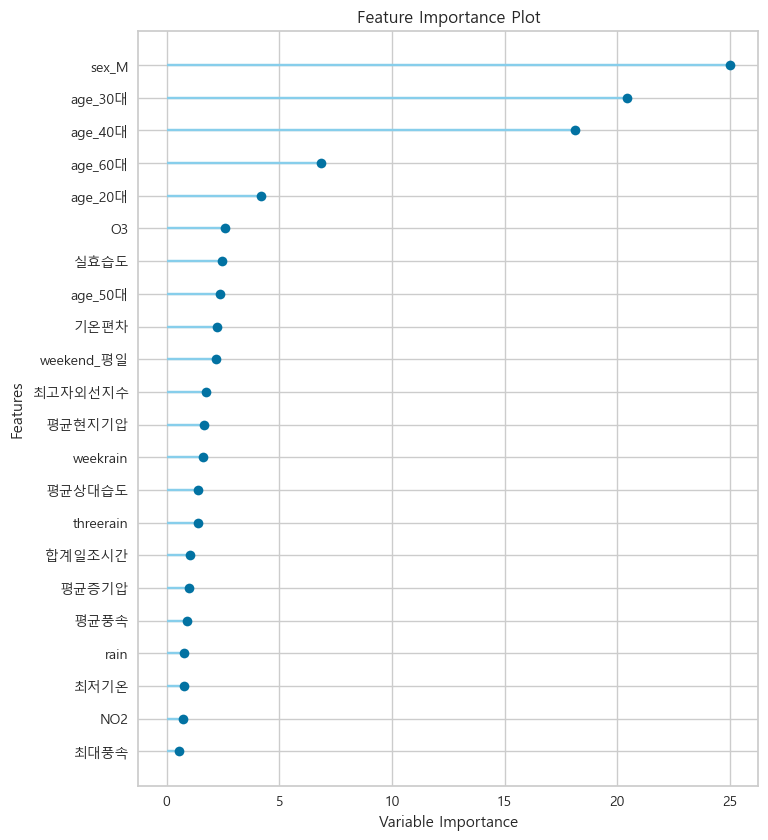

In [44]:
# 피쳐 중요도 확인
plot_model(model_01, 'feature_all' )

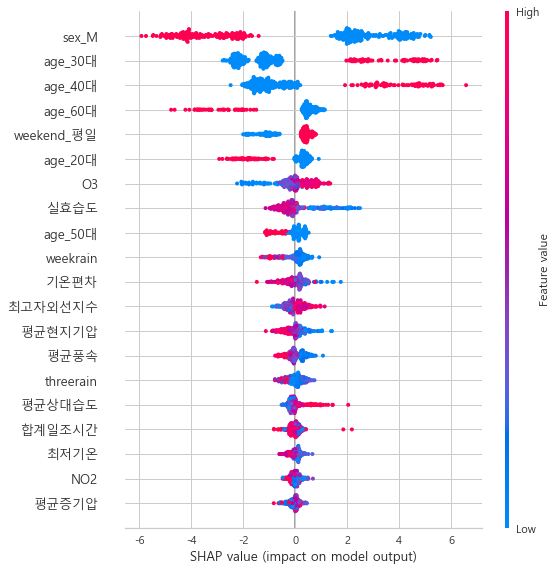

In [46]:
# Shap 확인 
interpret_model(model_01)